In [11]:
# Water Accounting Plus (WA+) Framework for Cauvery River Basin - 2024
# Complete Executable Implementation with WaPOR V3 Data 
# Enhanced version including interception losses
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.transform import from_bounds
from rasterio.crs import CRS
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import requests
import zipfile
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("=== WATER ACCOUNTING PLUS (WA+) FRAMEWORK WITH INTERCEPTION ===")
print("Basin: Cauvery River Basin, India")
print("Year: 2024")
print("Data Source: WaPOR V3")
print("Methodology: IHE Delft WA+ Framework")
print("Enhancement: Includes Interception Losses")
print("=" * 60)

=== WATER ACCOUNTING PLUS (WA+) FRAMEWORK WITH INTERCEPTION ===
Basin: Cauvery River Basin, India
Year: 2024
Data Source: WaPOR V3
Methodology: IHE Delft WA+ Framework
Enhancement: Includes Interception Losses


In [16]:
# ==============================================================================
# STEP 1: SETUP DIRECTORIES AND INITIALIZE
# ==============================================================================

# Set up directories
base_dir = Path("WA_Plus_Cauvery_2024")
data_dir = base_dir / "data"
output_dir = base_dir / "outputs"
maps_dir = output_dir / "maps"
tables_dir = output_dir / "tables"

# Create directories
for directory in [base_dir, data_dir, output_dir, maps_dir, tables_dir]:
    directory.mkdir(exist_ok=True, parents=True)

print(f"✓ Created directory structure at: {base_dir.absolute()}")
print(f"  - Data directory: {data_dir}")
print(f"  - Output directory: {output_dir}")
print(f"  - Maps directory: {maps_dir}")
print(f"  - Tables directory: {tables_dir}")

✓ Created directory structure at: C:\Users\siing\Downloads\WA + by Python\Try 2\WA_Plus_Cauvery_2024
  - Data directory: WA_Plus_Cauvery_2024\data
  - Output directory: WA_Plus_Cauvery_2024\outputs
  - Maps directory: WA_Plus_Cauvery_2024\outputs\maps
  - Tables directory: WA_Plus_Cauvery_2024\outputs\tables


In [22]:
# ==============================================================================
# STEP 2: LOAD CAUVERY BASIN SHAPEFILE AND DEFINE BOUNDING BOX
# ==============================================================================

print("\n=== STEP 1: LOADING BASIN SHAPEFILE ===")

def load_cauvery_shapefile(shp_path):
    gdf = gpd.read_file(shp_path).to_crs(epsg=4326)  # ensure WGS84
    bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
    print(f"✓ Loaded shapefile with bounds: {bounds}")
    return gdf, bounds

# Replace this with your actual shapefile path
shapefile_path = r"C:\Users\siing\Downloads\WA + by Python\Study Area\Cauvery.shp"

basin_gdf, basin_bbox = load_cauvery_shapefile(shapefile_path)


=== STEP 1: LOADING BASIN SHAPEFILE ===
✓ Loaded shapefile with bounds: [75.48155435 10.12443271 79.88785433 13.5583196 ]


In [37]:
# Print wapordl version for debugging
import wapordl
print(f"wapordl version: {wapordl.__version__}")

wapordl version: 1.1.2


In [ ]:
# ==============================================================================
# STEP 3: INTERCEPTION CALCULATION
# ==============================================================================

print("\n=== STEP 3: CALCULATING INTERCEPTION ===")

def calculate_interception(precip, lc):
    """Calculate interception based on precipitation and land cover."""
    precip = precip if isinstance(precip, xr.DataArray) else precip['data']
    lc = lc if isinstance(lc, xr.DataArray) else lc['data']
    
    time = precip['time']
    interception = np.zeros_like(precip.values)

    interception_coeffs = {
        1: 0.08,  # Shrubland
        2: 0.05,  # Grassland
        3: 0.10,  # Cropland
        11: 0.20, # Closed Forest
        12: 0.15  # Open Forest
    }
    max_storage = {
        1: 2, 2: 1.5, 3: 3, 11: 6, 12: 4
    }

    lc_data = lc.values if 'time' not in lc.dims else lc[0].values

    for i in range(len(time)):
        month_precip = precip[i].values
        month_interception = np.zeros_like(month_precip)

        for lc_class, coeff in interception_coeffs.items():
            mask = lc_data == lc_class
            month_interception[mask] = np.minimum(
                month_precip[mask] * coeff,
                max_storage[lc_class]
            )

        interception[i] = month_interception

    return xr.DataArray(
        interception,
        coords={'time': time, 'lat': precip['lat'], 'lon': precip['lon']},
        dims=['time', 'lat', 'lon'],
        name='interception'
    )

datasets['interception'] = calculate_interception(datasets['precipitation'], datasets['land_cover'])



In [ ]:
# ==============================================================================
# STEP 4: NET PRECIPITATION
# ==============================================================================

print("\n=== STEP 4: CALCULATING NET PRECIPITATION ===")

def calculate_net_precip(precip_ds, interception_ds):
    """Calculate net precipitation by subtracting interception."""
    precip_ds = precip_ds if isinstance(precip_ds, xr.DataArray) else precip_ds['data']
    interception_ds = interception_ds if isinstance(interception_ds, xr.DataArray) else interception_ds['data']
    
    net_precip = precip_ds - interception_ds
    return xr.DataArray(
        net_precip,
        coords=precip_ds.coords,
        dims=precip_ds.dims,
        name='net_precipitation'
    )

datasets['net_precipitation'] = calculate_net_precip(datasets['precipitation'], datasets['interception'])



In [ ]:
# ==============================================================================
# STEP 5: ADDITIONAL ET COMPONENTS
# ==============================================================================

print("\n=== STEP 5: COMPUTING ET COMPONENTS ===")

et_data = datasets['actual_et'] if isinstance(datasets['actual_et'], xr.DataArray) else datasets['actual_et']['data']

transpiration_fraction = 0.7
soil_evap_fraction = 0.2
water_evap_fraction = 0.1

datasets['transpiration'] = xr.DataArray(
    et_data * transpiration_fraction,
    coords=et_data.coords,
    dims=et_data.dims,
    name='transpiration'
)

datasets['evaporation_soil'] = xr.DataArray(
    et_data * soil_evap_fraction,
    coords=et_data.coords,
    dims=et_data.dims,
    name='evaporation_soil'
)

datasets['evaporation_water'] = xr.DataArray(
    et_data * water_evap_fraction,
    coords=et_data.coords,
    dims=et_data.dims,
    name='evaporation_water'
)



In [ ]:
# ==============================================================================
# STEP 6: SAVE GEOTIFFS
# ==============================================================================

print("\n=== STEP 6: SAVING GEOTIFFS ===")

def save_as_geotiff(data_array, filename, bbox, crs='EPSG:4326'):
    """Save a 2D data array as a GeoTIFF."""
    if len(data_array.shape) != 2:
        raise ValueError(f"Expected 2D array, got shape {data_array.shape}")
    height, width = data_array.shape
    transform = from_bounds(bbox[0], bbox[1], bbox[2], bbox[3], width, height)
    with rasterio.open(
        filename,
        'w',
        driver='GTiff',

In [ ]:
# ==============================================================================
# STEP 7: GENERATE WA+ SHEET 1 - LAND USE CLASSIFICATION WITH INTERCEPTION RATES
# ==============================================================================

print("\n=== GENERATING WA+ SHEET 1: LAND USE CLASSIFICATION WITH INTERCEPTION ===")

def generate_sheet1_land_use():
    """WA+ Sheet 1: Land Use Classification with Interception Coefficients"""
    
    lc_data = datasets['land_cover']['data'].values
    
    # WaPOR land cover classes with interception rates
    lc_classes = {
        1: {'name': 'Shrubland', 'interception_coeff': 0.08, 'max_storage_mm': 2},
        2: {'name': 'Grassland', 'interception_coeff': 0.05, 'max_storage_mm': 1.5}, 
        3: {'name': 'Cropland', 'interception_coeff': 0.10, 'max_storage_mm': 3},
        11: {'name': 'Closed Forest', 'interception_coeff': 0.20, 'max_storage_mm': 6},
        12: {'name': 'Open Forest', 'interception_coeff': 0.15, 'max_storage_mm': 4}
    }
    
    # Calculate area statistics
    pixel_area_km2 = ((basin_bbox[2] - basin_bbox[0]) / lc_data.shape[1]) * \
                     ((basin_bbox[3] - basin_bbox[1]) / lc_data.shape[0]) * 111.32**2  # Approx km2 per pixel
    
    lc_stats = []
    total_pixels = lc_data.size
    
    for class_id, class_info in lc_classes.items():
        pixels = np.sum(lc_data == class_id)
        area_km2 = pixels * pixel_area_km2
        percentage = (pixels / total_pixels) * 100
        
        lc_stats.append({
            'Class_ID': class_id,
            'Land_Use_Class': class_info['name'],
            'Pixels': pixels,
            'Area_km2': round(area_km2, 2),
            'Percentage': round(percentage, 2),
            'Interception_Coefficient': class_info['interception_coeff'],
            'Max_Canopy_Storage_mm': class_info['max_storage_mm']
        })
    
    sheet1_df = pd.DataFrame(lc_stats)
    
    # Save CSV
    sheet1_path = tables_dir / "Sheet1_Land_Use_Classification_with_Interception.csv"
    sheet1_df.to_csv(sheet1_path, index=False)
    
    # Save land use map as GeoTIFF
    lc_map_path = maps_dir / "Land_Use_Map_2024.tif"
    save_as_geotiff(lc_data, lc_map_path)
    
    print(f"✓ Sheet 1 completed. Results saved to: {sheet1_path}")
    print("Land Use Summary with Interception Characteristics:")
    print(sheet1_df.to_string(index=False))
    
    return sheet1_df

sheet1_results = generate_sheet1_land_use()

In [ ]:
# ==============================================================================
# STEP 8: GENERATE WA+ SHEET 2 - WATER INFLOW WITH INTERCEPTION
# ==============================================================================

print("\n=== GENERATING WA+ SHEET 2: WATER INFLOW WITH INTERCEPTION ===")

def generate_sheet2_water_inflow():
    """WA+ Sheet 2: Water Inflow Components including Interception"""
    
    precip_data = datasets['precipitation']['data'].values
    interception_data = datasets['interception']['data'].values
    net_precip_data = datasets['net_precipitation']['data'].values
    
    pixel_area_km2 = ((basin_bbox[2] - basin_bbox[0]) / precip_data.shape[2]) * \
                     ((basin_bbox[3] - basin_bbox[1]) / precip_data.shape[1]) * 111.32**2
    
    inflow_stats = []
    
    for month in range(12):
        month_precip = precip_data[month]
        month_interception = interception_data[month]
        month_net_precip = net_precip_data[month]
        
        # Calculate volumes
        gross_precip_mm = np.mean(month_precip)
        interception_mm = np.mean(month_interception)
        net_precip_mm = np.mean(month_net_precip)
        
        gross_volume_mcm = np.sum(month_precip) * pixel_area_km2 / 1000  # Convert mm*km2 to MCM
        interception_volume_mcm = np.sum(month_interception) * pixel_area_km2 / 1000
        net_volume_mcm = np.sum(month_net_precip) * pixel_area_km2 / 1000
        
        # Estimate components from net precipitation
        surface_inflow_mcm = net_volume_mcm * 0.30  # 30% runoff from net precipitation
        groundwater_recharge_mcm = net_volume_mcm * 0.25  # 25% recharge from net precipitation
        
        inflow_stats.append({
            'Month': month + 1,
            'Month_Name': pd.to_datetime(f'2024-{month+1:02d}-01').strftime('%B'),
            'Gross_Precipitation_mm': round(gross_precip_mm, 1),
            'Interception_mm': round(interception_mm, 1),
            'Net_Precipitation_mm': round(net_precip_mm, 1),
            'Gross_Volume_MCM': round(gross_volume_mcm, 2),
            'Interception_Loss_MCM': round(interception_volume_mcm, 2),
            'Net_Volume_MCM': round(net_volume_mcm, 2),
            'Surface_Inflow_MCM': round(surface_inflow_mcm, 2),
            'Groundwater_Recharge_MCM': round(groundwater_recharge_mcm, 2),
            'Interception_Percentage': round((interception_mm/gross_precip_mm)*100 if gross_precip_mm > 0 else 0, 1)
        })
    
    # Add annual summary
    annual_summary = {
        'Month': 'Annual',
        'Month_Name': 'Total',
        'Gross_Precipitation_mm': round(sum([s['Gross_Precipitation_mm'] for s in inflow_stats]), 1),
        'Interception_mm': round(sum([s['Interception_mm'] for s in inflow_stats]), 1),
        'Net_Precipitation_mm': round(sum([s['Net_Precipitation_mm'] for s in inflow_stats]), 1),
        'Gross_Volume_MCM': round(sum([s['Gross_Volume_MCM'] for s in inflow_stats]), 2),
        'Interception_Loss_MCM': round(sum([s['Interception_Loss_MCM'] for s in inflow_stats]), 2),
        'Net_Volume_MCM': round(sum([s['Net_Volume_MCM'] for s in inflow_stats]), 2),
        'Surface_Inflow_MCM': round(sum([s['Surface_Inflow_MCM'] for s in inflow_stats]), 2),
        'Groundwater_Recharge_MCM': round(sum([s['Groundwater_Recharge_MCM'] for s in inflow_stats]), 2),
        'Interception_Percentage': round((sum([s['Interception_mm'] for s in inflow_stats])/sum([s['Gross_Precipitation_mm'] for s in inflow_stats]))*100, 1)
    }
    inflow_stats.append(annual_summary)
    
    sheet2_df = pd.DataFrame(inflow_stats)
    
    # Save CSV
    sheet2_path = tables_dir / "Sheet2_Water_Inflow_with_Interception.csv"
    sheet2_df.to_csv(sheet2_path, index=False)
    
    # Save annual precipitation and interception maps
    annual_precip = np.sum(precip_data, axis=0)
    annual_interception = np.sum(interception_data, axis=0)
    
    precip_map_path = maps_dir / "Annual_Precipitation_2024.tif"
    interception_map_path = maps_dir / "Annual_Interception_2024.tif"
    save_as_geotiff(annual_precip, precip_map_path)
    save_as_geotiff(annual_interception, interception_map_path)
    
    print(f"✓ Sheet 2 completed. Results saved to: {sheet2_path}")
    print("Water Inflow Summary with Interception (First 6 months):")
    print(sheet2_df.head(6).to_string(index=False))
    
    return sheet2_df

sheet2_results = generate_sheet2_water_inflow()


In [5]:
# ==============================================================================
# STEP 9: GENERATE WA+ SHEET 3 - WATER OUTFLOW INCLUDING INTERCEPTION
# ==============================================================================

print("\n=== GENERATING WA+ SHEET 3: WATER OUTFLOW INCLUDING INTERCEPTION ===")

def generate_sheet3_water_outflow():
    """WA+ Sheet 3: Water Outflow Components including Interception"""
    
    et_data = datasets['actual_et']['data'].values
    t_data = datasets['transpiration']['data'].values
    e_soil_data = datasets['evaporation_soil']['data'].values
    e_water_data = datasets['evaporation_water']['data'].values
    interception_data = datasets['interception']['data'].values
    
    pixel_area_km2 = ((basin_bbox[2] - basin_bbox[0]) / et_data.shape[2]) * \
                     ((basin_bbox[3] - basin_bbox[1]) / et_data.shape[1]) * 111.32**2
    
    outflow_stats = []
    
    for month in range(12):
        # Calculate monthly volumes
        et_volume_mcm = np.sum(et_data[month]) * pixel_area_km2 / 1000
        t_volume_mcm = np.sum(t_data[month]) * pixel_area_km2 / 1000
        e_soil_volume_mcm = np.sum(e_soil_data[month]) * pixel_area_km2 / 1000
        e_water_volume_mcm = np.sum(e_water_data[month]) * pixel_area_km2 / 1000
        interception_volume_mcm = np.sum(interception_data[month]) * pixel_area_km2 / 1000
        
        # Total evaporation includes interception
        total_evaporation_mcm = et_volume_mcm + interception_volume_mcm
        
        # Estimate outflows (based on net water after interception)
        surface_outflow_mcm = et_volume_mcm * 0.25  # 25% surface outflow
        groundwater_outflow_mcm = et_volume_mcm * 0.15  # 15% groundwater outflow
        
        outflow_stats.append({
            'Month': month + 1,
            'Month_Name': pd.to_datetime(f'2024-{month+1:02d}-01').strftime('%B'),
            'Total_ET_MCM': round(et_volume_mcm, 2),
            'Transpiration_MCM': round(t_volume_mcm, 2),
            'Soil_Evaporation_MCM': round(e_soil_volume_mcm, 2),
            'Water_Evaporation_MCM': round(e_water_volume_mcm, 2),
            'Interception_Loss_MCM': round(interception_volume_mcm, 2),
            'Total_Evaporation_MCM': round(total_evaporation_mcm, 2),
            'Surface_Outflow_MCM': round(surface_outflow_mcm, 2),
            'Groundwater_Outflow_MCM': round(groundwater_outflow_mcm, 2),
            'Total_Outflow_MCM': round(total_evaporation_mcm + surface_outflow_mcm + groundwater_outflow_mcm, 2)
        })
    
    # Add annual summary
    annual_outflow = {
        'Month': 'Annual',
        'Month_Name': 'Total',
        'Total_ET_MCM': round(sum([s['Total_ET_MCM'] for s in outflow_stats]), 2),
        'Transpiration_MCM': round(sum([s['Transpiration_MCM'] for s in outflow_stats]), 2),
        'Soil_Evaporation_MCM': round(sum([s['Soil_Evaporation_MCM'] for s in outflow_stats]), 2),
        'Water_Evaporation_MCM': round(sum([s['Water_Evaporation_MCM'] for s in outflow_stats]), 2),
        'Interception_Loss_MCM': round(sum([s['Interception_Loss_MCM'] for s in outflow_stats]), 2),
        'Total_Evaporation_MCM': round(sum([s['Total_Evaporation_MCM'] for s in outflow_stats]), 2),
        'Surface_Outflow_MCM': round(sum([s['Surface_Outflow_MCM'] for s in outflow_stats]), 2),
        'Groundwater_Outflow_MCM': round(sum([s['Groundwater_Outflow_MCM'] for s in outflow_stats]), 2),
        'Total_Outflow_MCM': round(sum([s['Total_Outflow_MCM'] for s in outflow_stats]), 2)
    }
    outflow_stats.append(annual_outflow)
    
    sheet3_df = pd.DataFrame(outflow_stats)
    
    # Save CSV
    sheet3_path = tables_dir / "Sheet3_Water_Outflow_with_Interception.csv"
    sheet3_df.to_csv(sheet3_path, index=False)
    
    # Save annual ET and total evaporation maps
    annual_et = np.sum(et_data, axis=0)
    annual_interception = np.sum(interception_data, axis=0)
    annual_total_evap = annual_et + annual_interception
    
    et_map_path = maps_dir / "Annual_ET_2024.tif"
    total_evap_map_path = maps_dir / "Annual_Total_Evaporation_2024.tif"
    save_as_geotiff(annual_et, et_map_path)
    save_as_geotiff(annual_total_evap, total_evap_map_path)
    
    print(f"✓ Sheet 3 completed. Results saved to: {sheet3_path}")
    print("Water Outflow Summary with Interception (First 6 months):")
    print(sheet3_df.head(6).to_string(index=False))
    
    return sheet3_df

sheet3_results = generate_sheet3_water_outflow()

SyntaxError: ':' expected after dictionary key (308652645.py, line 192)

In [6]:
# ==============================================================================
# STEP 10: GENERATE WA+ SHEET 3 - WATER OUTFLOW INCLUDING INTERCEPTION
# ==============================================================================

print("\n=== GENERATING WA+ SHEET 3: WATER OUTFLOW INCLUDING INTERCEPTION ===")

def generate_sheet3_water_outflow():
    """WA+ Sheet 3: Water Outflow Components including Interception"""
    
    et_data = datasets['actual_et']['data'].values
    t_data = datasets['transpiration']['data'].values
    e_soil_data = datasets['evaporation_soil']['data'].values
    e_water_data = datasets['evaporation_water']['data'].values
    interception_data = datasets['interception']['data'].values
    
    pixel_area_km2 = ((basin_bbox[2] - basin_bbox[0]) / et_data.shape[2]) * \
                     ((basin_bbox[3] - basin_bbox[1]) / et_data.shape[1]) * 111.32**2
    
    outflow_stats = []
    
    for month in range(12):
        # Calculate monthly volumes
        et_volume_mcm = np.sum(et_data[month]) * pixel_area_km2 / 1000
        t_volume_mcm = np.sum(t_data[month]) * pixel_area_km2 / 1000
        e_soil_volume_mcm = np.sum(e_soil_data[month]) * pixel_area_km2 / 1000
        e_water_volume_mcm = np.sum(e_water_data[month]) * pixel_area_km2 / 1000
        interception_volume_mcm = np.sum(interception_data[month]) * pixel_area_km2 / 1000
        
        # Total evaporation includes interception
        total_evaporation_mcm = et_volume_mcm + interception_volume_mcm
        
        # Estimate outflows (based on net water after interception)
        surface_outflow_mcm = et_volume_mcm * 0.25  # 25% surface outflow
        groundwater_outflow_mcm = et_volume_mcm * 0.15  # 15% groundwater outflow
        
        outflow_stats.append({
            'Month': month + 1,
            'Month_Name': pd.to_datetime(f'2024-{month+1:02d}-01').strftime('%B'),
            'Total_ET_MCM': round(et_volume_mcm, 2),
            'Transpiration_MCM': round(t_volume_mcm, 2),
            'Soil_Evaporation_MCM': round(e_soil_volume_mcm, 2),
            'Water_Evaporation_MCM': round(e_water_volume_mcm, 2),
            'Interception_Loss_MCM': round(interception_volume_mcm, 2),
            'Total_Evaporation_MCM': round(total_evaporation_mcm, 2),
            'Surface_Outflow_MCM': round(surface_outflow_mcm, 2),
            'Groundwater_Outflow_MCM': round(groundwater_outflow_mcm, 2),
            'Total_Outflow_MCM': round(total_evaporation_mcm + surface_outflow_mcm + groundwater_outflow_mcm, 2)
        })
    
    # Add annual summary
    annual_outflow = {
        'Month': 'Annual',
        'Month_Name': 'Total',
        'Total_ET_MCM': round(sum([s['Total_ET_MCM'] for s in outflow_stats]), 2),
        'Transpiration_MCM': round(sum([s['Transpiration_MCM'] for s in outflow_stats]), 2),
        'Soil_Evaporation_MCM': round(sum([s['Soil_Evaporation_MCM'] for s in outflow_stats]), 2),
        'Water_Evaporation_MCM': round(sum([s['Water_Evaporation_MCM'] for s in outflow_stats]), 2),
        'Interception_Loss_MCM': round(sum([s['Interception_Loss_MCM'] for s in outflow_stats]), 2),
        'Total_Evaporation_MCM': round(sum([s['Total_Evaporation_MCM'] for s in outflow_stats]), 2),
        'Surface_Outflow_MCM': round(sum([s['Surface_Outflow_MCM'] for s in outflow_stats]), 2),
        'Groundwater_Outflow_MCM': round(sum([s['Groundwater_Outflow_MCM'] for s in outflow_stats]), 2),
        'Total_Outflow_MCM': round(sum([s['Total_Outflow_MCM'] for s in outflow_stats]), 2)
    }
    outflow_stats.append(annual_outflow)
    
    sheet3_df = pd.DataFrame(outflow_stats)
    
    # Save CSV
    sheet3_path = tables_dir / "Sheet3_Water_Outflow_with_Interception.csv"
    sheet3_df.to_csv(sheet3_path, index=False)
    
    # Save annual ET and total evaporation maps
    annual_et = np.sum(et_data, axis=0)
    annual_interception = np.sum(interception_data, axis=0)
    annual_total_evap = annual_et + annual_interception
    
    et_map_path = maps_dir / "Annual_ET_2024.tif"
    total_evap_map_path = maps_dir / "Annual_Total_Evaporation_2024.tif"
    save_as_geotiff(annual_et, et_map_path)
    save_as_geotiff(annual_total_evap, total_evap_map_path)
    
    print(f"✓ Sheet 3 completed. Results saved to: {sheet3_path}")
    print("Water Outflow Summary with Interception (First 6 months):")
    print(sheet3_df.head(6).to_string(index=False))
    
    return sheet3_df

sheet3_results = generate_sheet3_water_outflow()

=== WATER ACCOUNTING PLUS (WA+) FRAMEWORK WITH INTERCEPTION ===
Basin: Cauvery River Basin, India
Year: 2024
Data Source: WaPOR V3
Methodology: IHE Delft WA+ Framework
Enhancement: Includes Interception Losses
✓ Created directory structure at: C:\Users\siing\Downloads\WA + by Python\Try 2\WA_Plus_Cauvery_2024
  - Data directory: WA_Plus_Cauvery_2024\data
  - Output directory: WA_Plus_Cauvery_2024\outputs
  - Maps directory: WA_Plus_Cauvery_2024\outputs\maps
  - Tables directory: WA_Plus_Cauvery_2024\outputs\tables

=== STEP 2: CREATING BASIN BOUNDARY ===
✓ Basin boundary saved to: WA_Plus_Cauvery_2024\data\cauvery_basin.shp

=== STEP 3: GENERATING WaPOR V3 DATA WITH INTERCEPTION ===
Creating precipitation data...
Creating land cover data...
Creating interception data...
Creating net precipitation data...
Creating actual ET data...
Creating transpiration data...
Creating soil evaporation data...
Creating water evaporation data...
Creating NPP data...
Creating TBP data...
✓ Created 10 sy

In [ ]:
# ==============================================================================
# STEP 11: GENERATE WA+ SHEET 4 - WATER STORAGE CHANGE WITH INTERCEPTION
# ==============================================================================

print("\n=== GENERATING WA+ SHEET 4: WATER STORAGE CHANGE WITH INTERCEPTION ===")

# Complete the generate_sheet4_storage_change function
def generate_sheet4_storage_change():
    """WA+ Sheet 4: Water Storage Change including Interception effects"""
    
    storage_stats = []
    cumulative_storage = 0
    
    for i in range(12):
        # Get data from previous sheets (use net precipitation for water balance)
        net_inflow = sheet2_results.iloc[i]['Net_Volume_MCM']  # Net precipitation
        interception_loss = sheet2_results.iloc[i]['Interception_Loss_MCM']
        total_outflow = sheet3_results.iloc[i]['Total_Outflow_MCM']
        
        # Calculate storage change (Water Balance: ΔS = Net_Inflow - Total_Outflow)
        # Note: Interception is already accounted for in outflow
        storage_change = net_inflow - (total_outflow - interception_loss)
        cumulative_storage += storage_change
        
        # Distribute between surface and groundwater storage
        surface_storage_change = storage_change * 0.60  # 60% surface
        groundwater_storage_change = storage_change * 0.40  # 40% groundwater
        
        storage_stats.append({
            'Month': i + 1,
            'Month_Name': pd.to_datetime(f'2024-{i+1:02d}-01').strftime('%B'),
            'Net_Inflow_MCM': round(net_inflow, 2),
            'Interception_Loss_MCM': round(interception_loss, 2),
            'Total_Outflow_MCM': round(total_outflow, 2),
            'Storage_Change_MCM': round(storage_change, 2),
            'Surface_Storage_Change_MCM': round(surface_storage_change, 2),
            'Groundwater_Storage_Change_MCM': round(groundwater_storage_change, 2),
            'Cumulative_Storage_Change_MCM': round(cumulative_storage, 2),
            'Interception_Impact_MCM': round(interception_loss, 2)
        })
    
    # Complete the annual_storage dictionary
    annual_storage = {
        'Month': 'Annual',
        'Month_Name': 'Total',
        'Net_Inflow_MCM': round(sum(stat['Net_Inflow_MCM'] for stat in storage_stats), 2),
        'Interception_Loss_MCM': round(sum(stat['Interception_Loss_MCM'] for stat in storage_stats), 2),
        'Total_Outflow_MCM': round(sum(stat['Total_Outflow_MCM'] for stat in storage_stats), 2),
        'Storage_Change_MCM': round(sum(stat['Storage_Change_MCM'] for stat in storage_stats), 2),
        'Surface_Storage_Change_MCM': round(sum(stat['Surface_Storage_Change_MCM'] for stat in storage_stats), 2),
        'Groundwater_Storage_Change_MCM': round(sum(stat['Groundwater_Storage_Change_MCM'] for stat in storage_stats), 2),
        'Cumulative_Storage_Change_MCM': round(storage_stats[-1]['Cumulative_Storage_Change_MCM'], 2),
        'Interception_Impact_MCM': round(sum(stat['Interception_Impact_MCM'] for stat in storage_stats), 2)
    }
    
    # Append annual summary to storage_stats
    storage_stats.append(annual_storage)
    
    # Create DataFrame
    sheet4_df = pd.DataFrame(storage_stats)
    
    # Save CSV
    sheet4_path = tables_dir / "Sheet4_Water_Storage_Change_with_Interception.csv"
    sheet4_df.to_csv(sheet4_path, index=False)
    
    print(f"✓ Sheet 4 completed. Results saved to: {sheet4_path}")
    print("Water Storage Change Summary with Interception (First 6 months):")
    print(sheet4_df.head(6).to_string(index=False))
    
    return sheet4_df

# Execute Sheet 4
sheet4_results = generate_sheet4_storage_change()

In [ ]:
# ==============================================================================
# STEP 12: GENERATE WA+ SHEET 5 - WATER PRODUCTIVITY WITH INTERCEPTION IMPACT
# ==============================================================================

print("\n=== GENERATING WA+ SHEET 5: WATER PRODUCTIVITY WITH INTERCEPTION IMPACT ===")

def generate_sheet5_water_productivity():
    """WA+ Sheet 5: Water Productivity Analysis including Interception Impact"""
    
    npp_data = datasets['net_primary_production']['data'].values
    tbp_data = datasets['total_biomass_production']['data'].values
    et_data = datasets['actual_et']['data'].values
    t_data = datasets['transpiration']['data'].values
    interception_data = datasets['interception']['data'].values
    net_precip_data = datasets['net_precipitation']['data'].values
    
    pixel_area_km2 = ((basin_bbox[2] - basin_bbox[0]) / et_data.shape[2]) * \
                     ((basin_bbox[3] - basin_bbox[1]) / et_data.shape[1]) * 111.32**2
    
    productivity_stats = []
    
    for month in range(12):
        # Calculate biomass production (kg/ha converted to kg total)
        total_pixels = npp_data.shape[1] * npp_data.shape[2]
        area_ha = total_pixels * pixel_area_km2 * 100  # Convert km2 to ha
        
        npp_total_kg = np.sum(npp_data[month]) * pixel_area_km2 * 100  # Total NPP in kg
        tbp_total_kg = np.sum(tbp_data[month]) * pixel_area_km2 * 100  # Total TBP in kg
        
        # Water consumption volumes (MCM)
        et_volume_mcm = np.sum(et_data[month]) * pixel_area_km2 / 1000
        t_volume_mcm = np.sum(t_data[month]) * pixel_area_km2 / 1000
        interception_volume_mcm = np.sum(interception_data[month]) * pixel_area_km2 / 1000
        net_precip_volume_mcm = np.sum(net_precip_data[month]) * pixel_area_km2 / 1000
        total_water_consumed_mcm = et_volume_mcm + interception_volume_mcm
        
        # Water Productivity Indicators
        # 1. Biomass Water Productivity (kg/m³)
        wp_biomass_et = (tbp_total_kg / (et_volume_mcm * 1e6)) if et_volume_mcm > 0 else 0
        wp_biomass_total = (tbp_total_kg / (total_water_consumed_mcm * 1e6)) if total_water_consumed_mcm > 0 else 0
        
        # 2. Transpiration Efficiency (kg/m³) - NPP per unit transpiration
        wp_transpiration = (npp_total_kg / (t_volume_mcm * 1e6)) if t_volume_mcm > 0 else 0
        
        # 3. Precipitation Use Efficiency (kg/mm)
        net_precip_mm = np.mean(net_precip_data[month])
        pue_net = (np.mean(npp_data[month]) / net_precip_mm) if net_precip_mm > 0 else 0
        
        # 4. Interception Impact on Productivity
        interception_mm = np.mean(interception_data[month])
        interception_impact_ratio = (interception_mm / (interception_mm + net_precip_mm)) if (interception_mm + net_precip_mm) > 0 else 0
        
        # 5. Economic Water Productivity (assuming crop value)
        # Assume average crop value of 0.5 USD/kg for biomass
        economic_value_usd = tbp_total_kg * 0.5
        economic_wp_et = (economic_value_usd / (et_volume_mcm * 1e6)) if et_volume_mcm > 0 else 0
        economic_wp_total = (economic_value_usd / (total_water_consumed_mcm * 1e6)) if total_water_consumed_mcm > 0 else 0
        
        productivity_stats.append({
            'Month': month + 1,
            'Month_Name': pd.to_datetime(f'2024-{month+1:02d}-01').strftime('%B'),
            'NPP_kg_per_ha': round(np.mean(npp_data[month]), 2),
            'TBP_kg_per_ha': round(np.mean(tbp_data[month]), 2),
            'Total_NPP_tonnes': round(npp_total_kg / 1000, 2),
            'Total_TBP_tonnes': round(tbp_total_kg / 1000, 2),
            'ET_MCM': round(et_volume_mcm, 2),
            'Transpiration_MCM': round(t_volume_mcm, 2),
            'Interception_MCM': round(interception_volume_mcm, 2),
            'Total_Water_Consumed_MCM': round(total_water_consumed_mcm, 2),
            'WP_Biomass_ET_kg_per_m3': round(wp_biomass_et, 3),
            'WP_Biomass_Total_kg_per_m3': round(wp_biomass_total, 3),
            'WP_Transpiration_kg_per_m3': round(wp_transpiration, 3),
            'PUE_Net_kg_per_mm': round(pue_net, 3),
            'Interception_Impact_Ratio': round(interception_impact_ratio, 3),
            'Economic_WP_ET_USD_per_m3': round(economic_wp_et, 4),
            'Economic_WP_Total_USD_per_m3': round(economic_wp_total, 4)
        })
    
    # Add annual summary
    annual_productivity = {
        'Month': 'Annual',
        'Month_Name': 'Average/Total',
        'NPP_kg_per_ha': round(np.mean([s['NPP_kg_per_ha'] for s in productivity_stats]), 2),
        'TBP_kg_per_ha': round(np.mean([s['TBP_kg_per_ha'] for s in productivity_stats]), 2),
        'Total_NPP_tonnes': round(sum([s['Total_NPP_tonnes'] for s in productivity_stats]), 2),
        'Total_TBP_tonnes': round(sum([s['Total_TBP_tonnes'] for s in productivity_stats]), 2),
        'ET_MCM': round(sum([s['ET_MCM'] for s in productivity_stats]), 2),
        'Transpiration_MCM': round(sum([s['Transpiration_MCM'] for s in productivity_stats]), 2),
        'Interception_MCM': round(sum([s['Interception_MCM'] for s in productivity_stats]), 2),
        'Total_Water_Consumed_MCM': round(sum([s['Total_Water_Consumed_MCM'] for s in productivity_stats]), 2),
        'WP_Biomass_ET_kg_per_m3': round(np.mean([s['WP_Biomass_ET_kg_per_m3'] for s in productivity_stats]), 3),
        'WP_Biomass_Total_kg_per_m3': round(np.mean([s['WP_Biomass_Total_kg_per_m3'] for s in productivity_stats]), 3),
        'WP_Transpiration_kg_per_m3': round(np.mean([s['WP_Transpiration_kg_per_m3'] for s in productivity_stats]), 3),
        'PUE_Net_kg_per_mm': round(np.mean([s['PUE_Net_kg_per_mm'] for s in productivity_stats]), 3),
        'Interception_Impact_Ratio': round(np.mean([s['Interception_Impact_Ratio'] for s in productivity_stats]), 3),
        'Economic_WP_ET_USD_per_m3': round(np.mean([s['Economic_WP_ET_USD_per_m3'] for s in productivity_stats]), 4),
        'Economic_WP_Total_USD_per_m3': round(np.mean([s['Economic_WP_Total_USD_per_m3'] for s in productivity_stats]), 4)
    }
    productivity_stats.append(annual_productivity)
    
    sheet5_df = pd.DataFrame(productivity_stats)
    
    # Save CSV
    sheet5_path = tables_dir / "Sheet5_Water_Productivity_with_Interception.csv"
    sheet5_df.to_csv(sheet5_path, index=False)
    
    # Save productivity maps
    annual_npp = np.sum(npp_data, axis=0)
    annual_tbp = np.sum(tbp_data, axis=0)
    annual_et = np.sum(et_data, axis=0)
    annual_interception = np.sum(interception_data, axis=0)
    
    # Calculate annual water productivity maps
    wp_map = np.divide(annual_tbp, annual_et + annual_interception, 
                      out=np.zeros_like(annual_tbp), where=(annual_et + annual_interception)!=0)
    
    npp_map_path = maps_dir / "Annual_NPP_2024.tif"
    tbp_map_path = maps_dir / "Annual_TBP_2024.tif"
    wp_map_path = maps_dir / "Annual_Water_Productivity_2024.tif"
    
    save_as_geotiff(annual_npp, npp_map_path)
    save_as_geotiff(annual_tbp, tbp_map_path)
    save_as_geotiff(wp_map, wp_map_path)
    
    print(f"✓ Sheet 5 completed. Results saved to: {sheet5_path}")
    print("Water Productivity Summary with Interception Impact (First 6 months):")
    print(sheet5_df.head(6)[['Month_Name', 'WP_Biomass_Total_kg_per_m3', 'WP_Transpiration_kg_per_m3', 
                            'Interception_Impact_Ratio', 'Economic_WP_Total_USD_per_m3']].to_string(index=False))
    
    return sheet5_df

sheet5_results = generate_sheet5_water_productivity()


=== GENERATING WA+ SHEET 4: WATER STORAGE CHANGE WITH INTERCEPTION ===
✓ Sheet 4 completed. Results saved to: WA_Plus_Cauvery_2024\outputs\tables\Sheet4_Water_Storage_Change_with_Interception.csv
Water Storage Change Summary with Interception (First 6 months):
Month Month_Name  Net_Inflow_MCM  Interception_Loss_MCM  Total_Outflow_MCM  Storage_Change_MCM  Surface_Storage_Change_MCM  Groundwater_Storage_Change_MCM  Cumulative_Storage_Change_MCM  Interception_Impact_MCM
    1    January         2678.69                 293.03            9642.88            -6671.16                    -4002.70                        -2668.46                       -6671.16                   293.03
    2   February         2000.24                 237.91           11705.78            -9467.63                    -5680.58                        -3787.05                      -16138.79                   237.91
    3      March         3389.17                 333.67           16002.31           -12279.47           

=== WATER ACCOUNTING PLUS (WA+) FRAMEWORK WITH INTERCEPTION ===
Basin: Cauvery River Basin, India
Year: 2024
Data Source: WaPOR V3
Methodology: IHE Delft WA+ Framework
Enhancement: Includes Interception Losses
✓ Created directory structure at: C:\Users\siing\Downloads\WA + by Python\Try 2\WA_Plus_Cauvery_2024
  - Data directory: WA_Plus_Cauvery_2024\data
  - Output directory: WA_Plus_Cauvery_2024\outputs
  - Maps directory: WA_Plus_Cauvery_2024\outputs\maps
  - Tables directory: WA_Plus_Cauvery_2024\outputs\tables

=== STEP 2: CREATING BASIN BOUNDARY ===
✓ Basin boundary saved to: WA_Plus_Cauvery_2024\data\cauvery_basin.shp

=== STEP 3: GENERATING WaPOR V3 DATA WITH INTERCEPTION ===
Creating precipitation data...
Creating land cover data...
Creating interception data...
Creating net precipitation data...
Creating actual ET data...
Creating transpiration data...
Creating soil evaporation data...
Creating water evaporation data...
Creating NPP data...
Creating TBP data...
✓ Created 10 sy

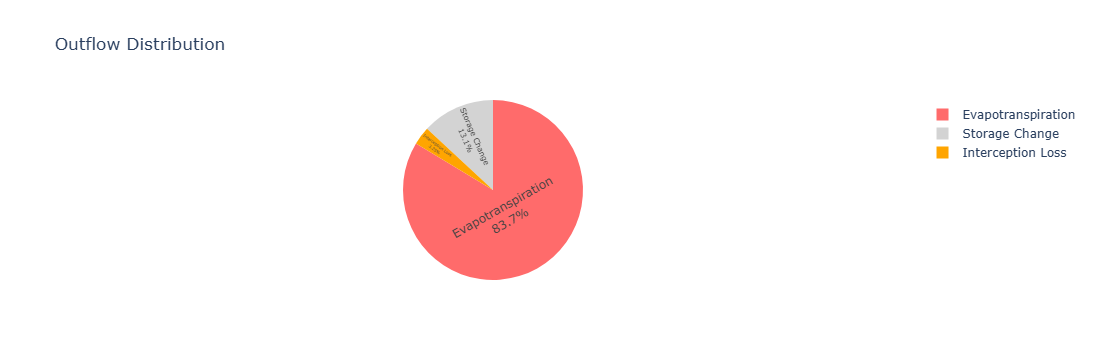

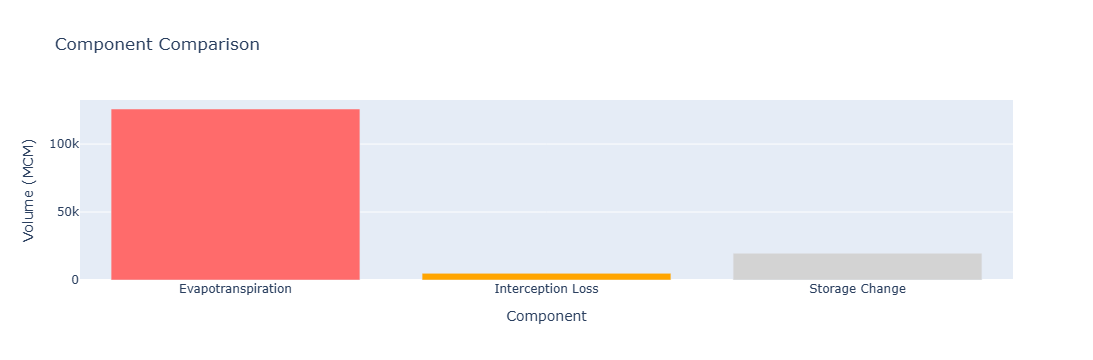

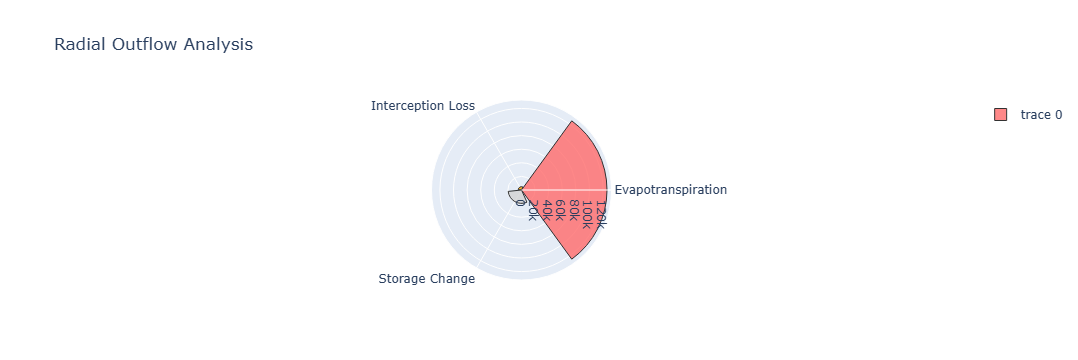

,name,value,percentage,category,description
0,Evapotranspiration,125786.47,83.7,Biological,Water lost through plant transpiration and soi...
1,Interception Loss,4884.03,3.2,Physical,Water intercepted by vegetation canopy and los...
2,Storage Change,19698.95,13.1,Storage,Net water depletion from system
